# 5 classification on a given dataset

## Imports

In [18]:
import numpy as np
import os
import sklearn.linear_model
import sklearn.metrics
import optuna
import sklearn.ensemble
import sklearn.pipeline
import sklearn.preprocessing

import keras.models
import keras.layers
import keras.optimizers
import keras.losses
import keras.regularizers


## Load data

In [3]:
PATH_DATA = "data/"
X_train = np.load(os.path.join(PATH_DATA, "X_train.npy"))
X_test = np.load(os.path.join(PATH_DATA, "X_test.npy"))
y_train = np.load(os.path.join(PATH_DATA, "y_train.npy"))
y_test = np.load(os.path.join(PATH_DATA, "y_test.npy"))

X_train.shape, y_test.shape, X_test.shape, y_test.shape

((500, 30), (500,), (500, 30), (500,))

In [4]:
for name, dataset in {"X_train": X_train, "X_test": X_test}.items():
    print(name)
    print(f"min : {dataset.min()}, max : {dataset.max()}, mean : {dataset.mean()}, std : {dataset.std()}")

X_train
min : -8.50564411497865, max : 12.487172901703206, mean : 0.032035713075211476, std : 1.4574044640994743
X_test
min : -8.51135504721533, max : 9.207033990941161, mean : 0.034826292206924826, std : 1.4591750582476128


In [5]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([241, 259])), (array([0, 1]), array([201, 299])))

## Load models

In [62]:
model = sklearn.linear_model.LogisticRegression()
model = sklearn.linear_model.SGDClassifier()
model = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(), sklearn.ensemble.RandomForestClassifier()
)

def init_NN(regu1 : float = 0.000001, regu2 : float = 0.0001):

    regu1 = keras.regularizers.L2(regu1)
    regu2 = keras.regularizers.L2(regu2)

    model = keras.models.Sequential([
        keras.layers.Normalization(input_dim=X_train.shape[1]),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=regu1),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=regu1),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regu1) 
    ])
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001), loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

model = init_NN()

/home/secouss/repos/FTML-Project/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train model

In [63]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5581 - loss: 0.7410 - val_accuracy: 0.5920 - val_loss: 0.6656
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 0.6773 - val_accuracy: 0.6800 - val_loss: 0.6124
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6431 - loss: 0.6235 - val_accuracy: 0.7320 - val_loss: 0.5775
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6569 - loss: 0.6240 - val_accuracy: 0.7600 - val_loss: 0.5505
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7142 - loss: 0.5695 - val_accuracy: 0.7640 - val_loss: 0.5263
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7047 - loss: 0.6099 - val_accuracy: 0.7780 - val_loss: 0.5152
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7092 - loss: 0.5450 - val_accuracy: 0.7760 - val_loss: 0.5016
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7359 - loss: 0.5396 - val_accuracy: 0.7800 - val_loss

## Evaluate

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.792
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       201
           1       0.88      0.75      0.81       299

    accuracy                           0.79       500
   macro avg       0.79      0.80      0.79       500
weighted avg       0.81      0.79      0.79       500



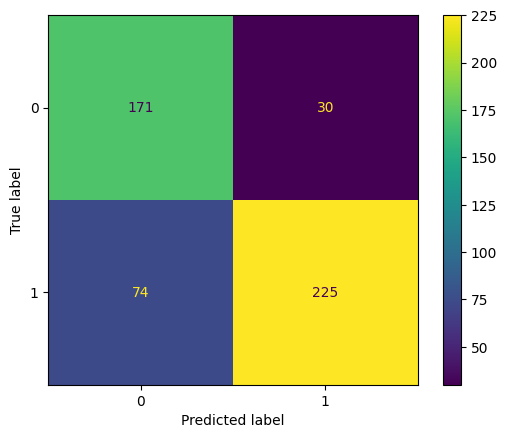

In [64]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")


print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, y_pred)}")

print("Classification Report:")
print(sklearn.metrics.classification_report(y_test, y_pred))

disp = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test, y_pred))
disp.plot()

## Optimize parameters

### Create the objectives function

In [35]:
def objective_lr(trial: optuna.trial.Trial):

    tol = trial.suggest_float("tol", 1e-12, 1e2)
    c = trial.suggest_float("C", 1e-12, 1e10)
    # solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"])
    # penalty = trial.suggest_categorical("penalty", [None, "l1", "l2"])
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1)

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.LogisticRegression(
            penalty="elasticnet",
            solver="saga",
            tol=tol,
            C=c,
            l1_ratio=l1_ratio,
            class_weight="balanced",
        ),
    )

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    return sklearn.metrics.accuracy_score(y_test, y_pred)


def objective_sgd(trial: optuna.trial.Trial):

    alpha = trial.suggest_float("alpha", 1e-12, 1e2)
    # l1_ratio = trial.suggest_float("l1_ratio", 0, 1)

    # losses = ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]
    # loss = trial.suggest_categorical("solver", losses)

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.SGDClassifier(
            loss="squared_error", alpha=alpha, penalty="l2"
        ),
    )

    estimator = sklearn.linear_model.SGDClassifier()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    return sklearn.metrics.accuracy_score(y_test, y_pred)


def objective_forest(trial: optuna.trial.Trial):

    criterion = trial.suggest_categorical(
        "criterion", ["gini", "entropy", "log_loss"]
    )
    n_estimators = trial.suggest_int("n_estimators", low=1, high=1000)
    max_depth = trial.suggest_int("max_depth", low=1, high=1000)
    min_samples_split = trial.suggest_float("min_samples_split", low=0, high=1)

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
        ),
    )

    estimator.fit(X_train, y_train)

    return estimator.score(X_test, y_test)


def objective_NN(trial: optuna.trial.Trial):

    kernel_regularizer = trial.suggest_float("kernel_regularizer", low=1e-12, high=1e-1)

    estimator = init_NN(kernel_regularizer)
    estimator.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    y_pred = estimator.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")

    return sklearn.metrics.accuracy_score(y_test, y_pred)



### Run the expirements

In [36]:
storage_name = "classification.db"
if os.path.exists(storage_name):
    os.remove(storage_name)

study = optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Classification",
        load_if_exists=False,
        direction="maximize",  # we want to maximize the R2 score
    )
study.optimize(func=objective_NN, n_trials=100)

[I 2024-06-18 19:07:01,392] A new study created in RDB with name: Classification
[W 2024-06-18 19:07:01,441] Trial 0 failed with parameters: {'kernel_regularizer': 0.029347346378559125} because of the following error: NameError("name 'init_NN' is not defined").
Traceback (most recent call last):
  File "/home/secouss/repos/FTML-Project/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_194088/4066793151.py", line 77, in objective_NN
    estimator = init_NN(kernel_regularizer)
NameError: name 'init_NN' is not defined
[W 2024-06-18 19:07:01,443] Trial 0 failed with value None.


NameError: name 'init_NN' is not defined

### Display the best results and hyperparameters

In [31]:
print(f"Best value: {study.best_value:.4f} (params: {study.best_params})")
for key, value in study.best_trial.params.items():
    if type(value) == float:
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

Best value: 0.6040 (params: {'kernel_regularizer': 0.8920139661100864})
kernel_regularizer: 0.89


### See all expirements results

In [124]:
!optuna-dashboard sqlite:///classification.db

[2024-06-18 18:34:18 +0200] [187363] [INFO] Starting gunicorn 22.0.0
[2024-06-18 18:34:18 +0200] [187363] [INFO] Listening at: http://127.0.0.1:8080 (187363)
[2024-06-18 18:34:18 +0200] [187363] [INFO] Using worker: gthread
[2024-06-18 18:34:18 +0200] [187380] [INFO] Booting worker with pid: 187380
/home/secouss/repos/FTML-Project/.venv/lib/python3.10/site-packages/optuna_dashboard/_importance.py:75: ExperimentalWarning: PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.
  return get_param_importances(study, target=target, evaluator=PedAnovaImportanceEvaluator())
/home/secouss/repos/FTML-Project/.venv/lib/python3.10/site-packages/optuna/importance/_ped_anova/evaluator.py:150: UserWarning: PedAnovaImportanceEvaluator computes the importances of params to achieve low `target` values. If this is not what you want, please modify target, e.g., by multiplying the output by -1.
  warnings.warn(
^C
[2024-06-18 18:35:02 +0200] [187363] [

## Conclusion

Analysess :
- regularization does not seems to improve performances
- positive must be set to true, otherwise the model will overfit

TODO